## How to rediscover the Higgs boson yourself!

NOTE:
- THE LEPTON ENERGIES IS NOW `lep_e` instead of `lep_E`
- everything is in GeV now (lep pt, lep E)
- change name for section on data_A

<CENTER><img src="images/ATLASOD.gif" style="width:50%"></CENTER>

This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

ATLAS Open Data provides open access to proton-proton collision data at the LHC for educational purposes. ATLAS Open Data resources are ideal for high-school, undergraduate and postgraduate students.

Notebooks are web applications that allow you to create and share documents that can contain for example:
1. live code
2. visualisations
3. narrative text


### What is the Higgs boson? 
The Higgs boson is a fundamental particle predicted by the Standard Model. 
It is a manifestation of the Higgs field,
    which gives mass to the fundamental particles.
However,
    it is incredibly hard to produce.
At the LHC, 
    a Higgs particle is produced about once every 10 billion collisions!
This tiny fraction makes it very difficult to detect.
Nevertheless, 
    after years of data collection, 
    the Higgs boson was finally discovered in 2012 by CMS and ATLAS experiments at CERN.
In this tutorial, 
    we shall be following their example. 


### Detecting the Higgs
This analysis loosely follows the paper on the [discovery of the Higgs boson by ATLAS](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (mostly Section 4 and 4.1).

The Higgs boson can be produced in many different ways. 
In particle physics, 
    we describe these production modes using Feynman diagrams.
These diagrams allow us to visualise particle processes while also acting as powerful tools for calculations.
See [here](https://cds.cern.ch/record/2759490/files/Feynman%20Diagrams%20-%20ATLAS%20Cheat%20Sheet.pdf) for more information on Feynman diagrams.

There are four main production modes of the Higgs boson, and their respective Feynman diagrams:
1. Gluon-gluon fusion (top left)
2. Vector boson fusion (top right)
3. Vector boson bremsstrahlung (bottom left)
4. Top-antitop fusion (bottom right)

<CENTER><img src="images/ggH.png" style="width:40%"> <img src="images/VBFH.png" style="width:35%"></CENTER>
<CENTER><img src="images/WH.png" style="width:40%"> <img src="images/ttbarfusion.png" style="width:35%"></CENTER>

The Higgs has a very short lifetime,
    on the order of $10^{-22} \,\text{s}$.
It decays extremely quickly after production,
    so there is no hope of directly detecting the particle.
Nevertheless,
    we can use the Standard Model to predict its 
    decay products: photons, Z bosons, quarks, etc.,
    all with different probabilities.
These **decay channels** can be used to identify the Higgs boson.
In this notebook, 
    we'll be looking at one particular decay channel:
$$H \rightarrow ZZ^* \rightarrow \ell\ell\ell\ell$$

<CENTER><img src="images/HZZ_feynman.png" style="width:40%"></CENTER>


We refer to this as our desired **signal**.
Ideally,
    we would search for collisions which yield four leptons as products and this would tell us that a Higgs boson is present.
Unfortunately,
    in addition to our signal,
    there are many other **background** processes that lead to four reconstructed leptons in the final state. 
The main background is $ZZ^*  \to \ell\ell\ell\ell$,
    where decay products have the same properties as those in the Higgs decay. 
This is known as an irreducible background. 
<CENTER><img src="images/ZZllll.png" style="width:40%"></CENTER>

We can get around this by accounting for the total invariant mass of the lepton products. 
We know through conservation of energy and momentum that the invariant mass of the products must be equal to the Higgs mass, 
    while other background processes will have different invariant masses. 
Our last step would be to plot the invariant mass of each event and spot the peak in mass around $125\, \text{GeV}$ , which corresponds to the mass of the Higgs boson. 

We also have background contributions from $Z +$ jets and top-anti top processes, 
    where additional charged leptons can arise either from semi-leptonic decays of heavy flavour or light flavour jets misidentified as leptons.
These backgrounds are difficult to remove completely. 

<CENTER><img src="images/Zllll.png" style="width:30%"><img src="images/ttbar.png" style="width:30%"></CENTER>

For such processes,
    we will attempt to distinguish them from the Higgs decay using the properties of the leptons.
Because the Higgs is a neutral particle with zero lepton number,
    the lepton products from its decay must sum to zero charge and zero lepton numbers.
Thus, 
    we can cut away all data with products that do not have these properties.
These cuts increase the ratio of our signal to the reducible background.

Note: $Z^*$ refers to a $Z$ boson that is off its mass shell. 
This means that its mass is not fixed to the $91 \, \text{GeV}$ of a typical $Z$ boson. 

By the end of this notebook you will be able to:
1. Learn to process large data sets using cuts
2. Understand some general principles of a particle physics analysis
3. Discover the Higgs boson!

See [here](https://cds.cern.ch/record/2800577/files/Signal%20and%20Background%20Physics%20Cheat%20Sheet.pdf) for more information on signals and backgrounds!

### Running a Python notebook
A Python notebook consists of cell blocks, 
    each containing lines of Python code.
Each cell can be run independently of each other,
    yielding respective outputs below the cells.
Conventionally,
    cells are run in order from top to bottom.


- To run the whole notebook, in the top menu click Cell $\to$ Run All.

- To propagate a change you've made to a piece of code, click Cell $\to$ Run All Below.

- You can also run a single code cell, by clicking Cell $\to$ Run Cells, or using the keyboard shortcut Shift+Enter.

For more information, 
    refer to [here](https://www.codecademy.com/article/how-to-use-jupyter-notebooks).

## ATLAS Open Data Initialisation

### First time package installation on your computer (not needed on mybinder)
This first cell installs the required python packages.
It only needs to be run the first time you open this notebook on your computer. 
If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If this is opened on mybinder, you don't need to run this cell.

In [1]:
import sys
import os.path
# update the pip package installer
# !{sys.executable} -m pip install --upgrade --user pip
# install required packages
# !{sys.executable} -m pip install --upgrade --user uproot awkward vector numpy matplotlib

We're going to import a number of packages to help us:
* `numpy`: provides numerical calculations such as histogramming
* `matplotlib`: common tool for making plots, figures, images, visualisations
* `uproot`: processes `.root` files typically used in particle physics into data formats used in python
* `awkward`: introduces `awkward` arrays, a format that generalizes `numpy` to nested data with possibly variable length lists
* `vector`: to allow vectorized 4-momentum calculations

In [2]:
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
import matplotlib_inline # to edit the inline plot format
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg') # to make plots in pdf (vector) format
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time

Unit definitions, as stored in the data files

In [3]:
MeV = 0.001
GeV = 1.0

## Example 1: Reading data 

We would like to read some of the data from the open dataset.

In [4]:
lumi = 36.6 # fb-1 # data size of the full release 

fraction = 1.0 # reduce this is if you want the code to run quicker

In [5]:
# CERN open database URL
skim = "exactly4lep"
path = "/storage/eirikgr/OpenData/merged/OD_FEB25/"+skim+"/"

For convenient naming and identification purposes,
    we define a dictionary which stores all the important names of the samples we want to pull from the database.

In [6]:
samples = {

    'data': {
        'list' : ['data15_periodD.exactly4lep','data15_periodF.exactly4lep',
                  'data15_periodH.exactly4lep','data16_periodA.exactly4lep',
                  'data16_periodC.exactly4lep','data16_periodE.exactly4lep',
                  'data16_periodG.exactly4lep','data16_periodK.exactly4lep',
                  'data15_periodE.exactly4lep','data15_periodG.exactly4lep',
                  'data15_periodJ.exactly4lep','data16_periodB.exactly4lep',
                  'data16_periodD.exactly4lep','data16_periodF.exactly4lep',
                  'data16_periodI.exactly4lep','data16_periodL.exactly4lep'],
    },   
    r'Background $Z,t\bar{t},t\bar{t}+V,VVV$' : { # Z+t+vvv
        'list' : [#'410472.PhPy8EG_A14_ttbar_hdamp258p75_dil.exactly4lep',
                  '410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.exactly4lep',
                    '410155.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttW.exactly4lep',
                    '410218.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttee.exactly4lep',
                    '410219.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttmumu.exactly4lep',
                    '412043.aMcAtNloPythia8EvtGen_A14NNPDF31_SM4topsNLO.exactly4lep',
                    '364243.Sherpa_222_NNPDF30NNLO_WWZ_4l2v_EW6.exactly4lep',
                    '364242.Sherpa_222_NNPDF30NNLO_WWW_3l3v_EW6.exactly4lep',
                    '364246.Sherpa_222_NNPDF30NNLO_WZZ_3l3v_EW6.exactly4lep',
                    '364248.Sherpa_222_NNPDF30NNLO_ZZZ_4l2v_EW6.exactly4lep',
                    '700320.Sh_2211_Zee_maxHTpTV2_BFilter.exactly4lep',
                    '700321.Sh_2211_Zee_maxHTpTV2_CFilterBVeto.exactly4lep',
                    '700322.Sh_2211_Zee_maxHTpTV2_CVetoBVeto.exactly4lep',
                    '700323.Sh_2211_Zmumu_maxHTpTV2_BFilter.exactly4lep',
                    '700324.Sh_2211_Zmumu_maxHTpTV2_CFilterBVeto.exactly4lep',
                    '700325.Sh_2211_Zmumu_maxHTpTV2_CVetoBVeto.exactly4lep'],
        'color' : "#6b59d3" # purple
    },
    r'Background $ZZ^{*}$' : { # ZZ
        'list' : ['700600.Sh_2212_llll.exactly4lep',
                  '700601.Sh_2212_lllv.exactly4lep'],
        'color' : "#ff0000" # red
    },
    r'Signal ($m_H$ = 125 GeV)' : { # H -> ZZ -> llll
        'list' : ['345060.PowhegPythia8EvtGen_NNLOPS_nnlo_30_ggH125_ZZ4l.exactly4lep',
                    '346228.PowhegPy8EG_NNPDF30_AZNLOCTEQ6L1_VBFH125_ZZ4lep_notau.exactly4lep',
                    '346311.PowhegPythia8EvtGen_NNPDF30_AZNLO_WpH125J_Wincl_H_incl_MINLO.exactly4lep',
                    '346312.PowhegPythia8EvtGen_NNPDF30_AZNLO_WmH125J_Wincl_H_incl_MINLO.exactly4lep',
                    '346340.PowhegPy8EG_A14NNPDF23_NNPDF30ME_ttH125_ZZ4l_allhad.exactly4lep',
                    '346341.PowhegPy8EG_A14NNPDF23_NNPDF30ME_ttH125_ZZ4l_semilep.exactly4lep',
                    '346342.PowhegPy8EG_A14NNPDF23_NNPDF30ME_ttH125_ZZ4l_dilep.exactly4lep'],
        'color' : "#00cdff" # light blue
    },
}

The key named `data` refers to the event information collected from real experiments,
    while the `Background` and `Signal` keys refer to Monte-Carlo (MC) simulations of the ATLAS experiments.
Both real data and MC data will then be analysed and compared together to discover the Higgs! 

Let's try accessing `data_A` in the CERN database URL as an example.

In [7]:
# Print the samples dict for the key 'data'
print(samples['data'])

# We shall use the first entry in 'list', 'data_A'
value = samples['data']['list'][0]
print(f"{value = }")

# This is now appended to our file path to retrieve the data_A.4lep.root file
data_A_path = path + "Data/" + value + ".root"

{'list': ['data15_periodD.exactly4lep', 'data15_periodF.exactly4lep', 'data15_periodH.exactly4lep', 'data16_periodA.exactly4lep', 'data16_periodC.exactly4lep', 'data16_periodE.exactly4lep', 'data16_periodG.exactly4lep', 'data16_periodK.exactly4lep', 'data15_periodE.exactly4lep', 'data15_periodG.exactly4lep', 'data15_periodJ.exactly4lep', 'data16_periodB.exactly4lep', 'data16_periodD.exactly4lep', 'data16_periodF.exactly4lep', 'data16_periodI.exactly4lep', 'data16_periodL.exactly4lep']}
value = 'data15_periodD.exactly4lep'


Next, we shall try opening the `data_A` file to see what is inside.
In the file (called a `tree`),
    there are 39 entries, 
    one for each event.
In each event,
    a dictionary stores the all relevant information as keys, such as the event number (`eventNumber`), lepton transverse momentum (`lep_pt`), etc.  
Details on the variables in the dictionary can be viewed [here](https://cds.cern.ch/record/2707171/files/ANA-OTRC-2019-01-PUB-updated.pdf) in Appendix A.

More information on trees can be viewed [here](https://masonproffitt.github.io/uproot-tutorial/03-trees/index.html).

In [8]:
# Accessing the file from the online database (":analysis" opens the tree in a desired manner)
tree = uproot.open(data_A_path + ":analysis")

# There are 39 entries in the tree
print(tree.num_entries)

# We can view all the information stored in the tree using the .keys() method.
print(tree.keys())

# We can also view the entire tree using the .arrays() method
# This generates a 39-entry list of dictionaries
print(tree.arrays()) 

3424
['num_events', 'sum_of_weights', 'sum_of_weights_squared', 'category', 'TriggerMatch_DILEPTON', 'ScaleFactor_MLTRIGGER', 'ScaleFactor_PILEUP', 'ScaleFactor_FTAG', 'mcWeight', 'xsec', 'filteff', 'kfac', 'channelNumber', 'eventNumber', 'runNumber', 'trigML', 'trigP', 'trigDT', 'trigT', 'trigE', 'trigDM', 'trigDE', 'trigM', 'trigMET', 'ScaleFactor_BTAG', 'ScaleFactor_JVT', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_e', 'jet_btag_quantile', 'jet_jvt', 'largeRJet_n', 'largeRJet_pt', 'largeRJet_eta', 'largeRJet_phi', 'largeRJet_e', 'largeRJet_m', 'largeRJet_D2', 'jet_pt_jer1', 'jet_pt_jer2', 'ScaleFactor_ELE', 'ScaleFactor_MUON', 'ScaleFactor_LepTRIGGER', 'ScaleFactor_MuTRIGGER', 'ScaleFactor_ElTRIGGER', 'lep_n', 'lep_type', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_e', 'lep_charge', 'lep_ptvarcone30', 'lep_topoetcone20', 'lep_z0', 'lep_d0', 'lep_d0sig', 'lep_isTightID', 'lep_isMediumID', 'lep_isLooseID', 'lep_isTightIso', 'lep_isLooseIso', 'lep_isTrigMatched', 'ScaleFactor_PHOTON', 'phot

Perhaps we'd like to see the lepton energies. 
We can access this from our tree using the key `lep_e`. 
Also, 
    from this point on we shall be manipulating our tree arrays using the `awkward` library.
We can use `library="ak"` in the argument of the `.arrays()` method to use this library.
If you ever see `library="ak"` in the code,
    it means that the array is output as an `awkward` array.

In [9]:
tree["lep_e"].arrays(library="ak")

<Array [{lep_e: [91.3, ..., 23.5]}, ..., {...}] type='3424 * {lep_e: var * ...'>

In our analysis, 
    not all the information in the tree is important.
We can store the important variables in a list and retrieve them from the tree later on.
As it turns out, 
    we will need the following set of variables:

In [10]:
# Define what variables are important to our analysis
variables = ['lep_pt','lep_eta','lep_phi','lep_e','lep_charge','lep_type','trigE','trigM','lep_isTrigMatched',
            'lep_isLooseID','lep_isMediumID','lep_isLooseIso','lep_type']

# To see all the data for our given variables
# for data in tree.iterate(variables, library="ak"):
#     print(data)

Now that we understand how to access the information in the `data_A` tree,
    we can begin analysis.
As mentioned in the introduction,
    there are two key steps to be completed for each event entry:
1. **Cuts** - we need to account for lepton selection rules in the event. 
In the [paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X), 
    it is stated that we must
"[select] two pairs of isolated leptons, each of which is comprised of two leptons with the **same flavour** and **opposite charge**".
The datasets used in this notebook have already been filtered to include at least 4 leptons per event.
We need to filter the data such that in each event, there are pairs of leptons of the **same lepton type** (`lep_type`) and summing to **zero lepton charge** (`lep_charge`).

2. **Mass calculation** - the data to be plotted is the 4-lepton invariant mass, which can be found using the equation: $$m_\text{4l} = \sqrt{E^2_\text{tot}-\mathbf{p}_\text{tot}\cdot\mathbf{p}_\text{tot}}$$
in units where $c=1$.
$E_\text{tot}$ is the total energy and $\mathbf{p}_\text{tot}$ is the total momentum.
This calculation is performed using the vector array method `.M` on the sum of lepton 4-momenta (`lep_pt`,`lep_eta`,`lep_phi`,`lep_E`).

From this,
    we can see why we chose those six important variables earlier. 
The physical reasoning for why we perform these steps is encapsulated in the idea of **conservation laws**.
You may read more [here](https://cds.cern.ch/record/2759491/files/Conservation%20Laws%20-%20ATLAS%20Physics%20Cheat%20Sheet.pdf).

Let's try to perform this two-step analysis for one event in `data_A`.

Define function to get data from files.

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

In [11]:
# This selects the first entry of the tree
entry = tree.arrays(library="ak")[:1] # EXPLAIN LIBRARY

# Cut lepton type (electron type is 11,  muon type is 13)
lep_type = entry['lep_type']
sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2] + lep_type[:, 3]
lep_type_cut_bool = (sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52)
print(f"Cut for lepton type? {lep_type_cut_bool}") # True means we should remove this entry (lepton type does not match)

# Cut lepton charge
# first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
lep_charge = entry['lep_charge']
sum_lep_charge = lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2] + lep_charge[:, 3] != 0
print(f"Cut for lepton charge? {sum_lep_charge}") # True means we should remove this entry (sum of lepton charges is not equal to 0)

# Calculate invariant mass of the 4-lepton state
# [:, i] selects the i-th lepton in each event
p4 = vector.zip({"pt": entry['lep_pt'], "eta": entry['lep_eta'], "phi": entry['lep_phi'], "E": entry['lep_e']})
invariant_mass = (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M # .M calculates the invariant mass
print(f"Invariant mass: {invariant_mass}")

Cut for lepton type? [True]
Cut for lepton charge? [False]
Invariant mass: [5.6]


Based on our analysis, this entry should be removed because the lepton type does not match our requirements.
We can turn these checks and calculations into a set of functions.

In [12]:
# Cut lepton type (electron type is 11,  muon type is 13)
def cut_lep_type(lep_type):
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2] + lep_type[:, 3]
    lep_type_cut_bool = (sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52)
    return lep_type_cut_bool # True means we should remove this entry (lepton type does not match)

# Cut lepton charge
def cut_lep_charge(lep_charge):
    # first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    sum_lep_charge = lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2] + lep_charge[:, 3] != 0
    return sum_lep_charge # True means we should remove this entry (sum of lepton charges is not equal to 0)

# Calculate invariant mass of the 4-lepton state
# [:, i] selects the i-th lepton in each event
def calc_mass(lep_pt, lep_eta, lep_phi, lep_e):
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_e})
    invariant_mass = (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M # .M calculates the invariant mass
    return invariant_mass


def cut_trig_match(lep_trigmatch): 
    trigmatch = lep_trigmatch  
    cut1 = ak.sum(trigmatch, axis=1) >= 1 
    return cut1

def cut_trig(trigE,trigM):
    return trigE | trigM


def ID_iso_cut(IDel,IDmu,isoel,isomu,pid): 
    thispid = pid 
    return (ak.sum(((thispid == 13) & IDmu & isomu) | ((thispid == 11) & IDel & isoel), axis=1) == 4)

You may verify on your own that these functions give the same outputs as the previous code block.
Now, 
    we shall apply these functions over the entire data tree using a `for` loop.

In [13]:
# Define empty list to hold all data for this sample
sample_data = []

# Perform the cuts for each data entry in the tree
for data in tree.iterate(variables, library="ak"): # the data will be in the form of an awkward array
    # We can use data[~boolean] to remove entries from the data set
    lep_type = data['lep_type']
    data = data[~cut_lep_type(lep_type)]
    lep_charge = data['lep_charge']
    data = data[~cut_lep_charge(lep_charge)]

    data['mass'] = calc_mass(data['lep_pt'], data['lep_eta'], data['lep_phi'], data['lep_e'])

    # Append data to the whole sample data list
    sample_data.append(data)

# turns sample_data back into an awkward array
data_A = ak.concatenate(sample_data)

We can now plot the data using Matplotlib. 
The data will be turned into a histogram,
    with bins of width $2.5 \,\text{GeV}$.
Note that much of the code written here is meant for the aesthetics of the plot.

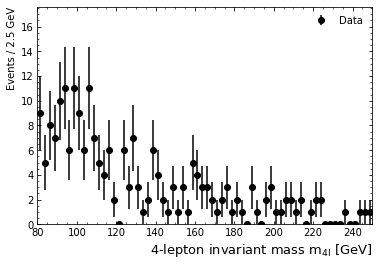

In [14]:
# x-axis range of the plot
xmin = 80 * GeV
xmax = 250 * GeV

# Histogram bin setup
step_size = 2.5 * GeV
bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

# Creating histogram from data
data_x,_ = np.histogram(ak.to_numpy(data_A['mass']), 
                        bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

# *************
# Main plot 
# *************
main_axes = plt.gca() # get current axes

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )

# add minor ticks on y-axis for main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# draw the legend
main_axes.legend( frameon=False ); # no box around the legend

Great,
    we managed to plot `data_A`! 
Now, 
    we have not discussed how to deal with the Monte-Carlo simulation data,
    or even what they are for. 
Let us explain.

## Example 2: Reading Monte-Carlo data


Using the Standard Model, 
    we can do a set of randomised simulations to produce a set of theoretical data points to compare to our ATLAS data.
These are known as Monte-Carlo(MC) simulations.
There is one important change to be made to the MC data before we can compare them with our ATLAS data:
 - **Weights** - The MC data was computed in ideal circumstances. 
    The real ATLAS detector has some inefficiencies,
        which we can account for by attributing the appropriate weight to each data point.
    The weight of a data point affects how it contributes to the histogram count for its bin.

Let's open an MC file.

In [15]:
# We open an MC data file with sample value "Zee" using samples and infofile for reference of filenames
print(samples[r'Background $Z,t\bar{t},t\bar{t}+V,VVV$'])
value = samples[r'Background $Z,t\bar{t},t\bar{t}+V,VVV$']["list"][0]

# This is now appended to our file path to retrieve the root file
background_ttbar_path = path + "MC/mc_"+ value + ".root"

# Accessing the file from the online database
tree = uproot.open(background_ttbar_path + ":analysis")

{'list': ['410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.exactly4lep', '410155.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttW.exactly4lep', '410218.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttee.exactly4lep', '410219.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttmumu.exactly4lep', '412043.aMcAtNloPythia8EvtGen_A14NNPDF31_SM4topsNLO.exactly4lep', '364243.Sherpa_222_NNPDF30NNLO_WWZ_4l2v_EW6.exactly4lep', '364242.Sherpa_222_NNPDF30NNLO_WWW_3l3v_EW6.exactly4lep', '364246.Sherpa_222_NNPDF30NNLO_WZZ_3l3v_EW6.exactly4lep', '364248.Sherpa_222_NNPDF30NNLO_ZZZ_4l2v_EW6.exactly4lep', '700320.Sh_2211_Zee_maxHTpTV2_BFilter.exactly4lep', '700321.Sh_2211_Zee_maxHTpTV2_CFilterBVeto.exactly4lep', '700322.Sh_2211_Zee_maxHTpTV2_CVetoBVeto.exactly4lep', '700323.Sh_2211_Zmumu_maxHTpTV2_BFilter.exactly4lep', '700324.Sh_2211_Zmumu_maxHTpTV2_CFilterBVeto.exactly4lep', '700325.Sh_2211_Zmumu_maxHTpTV2_CVetoBVeto.exactly4lep'], 'color': '#6b59d3'}


Again, 
    not all weights are important to our analysis. 
In our case, 
    these are:
- `mcWeight` - specific Monte-Carlo weight associated with each event
- `scaleFactor_PILEUP` - scale factor for pileup reweighting
- `scaleFactor_ELE` - scale factor for electron efficiency
- `scaleFactor_MUON`- scale factor for muon efficiency
- `scaleFactor_LepTRIGGER` - scale factor for lepton triggers (TODO not around for new release)

Scale factors are generally related to estimates of the efficiencies and resolutions of detectors.

In [16]:
weight_variables = ["filteff","kfac","xsec","mcWeight","ScaleFactor_PILEUP", "ScaleFactor_ELE", "ScaleFactor_MUON", "ScaleFactor_LepTRIGGER"]

# For example, see below for the weights corresponding to muon rejection
tree["ScaleFactor_MUON"].arrays(library = "ak")
print(weight_variables)

['filteff', 'kfac', 'xsec', 'mcWeight', 'ScaleFactor_PILEUP', 'ScaleFactor_ELE', 'ScaleFactor_MUON', 'ScaleFactor_LepTRIGGER']


Additionally,
    there is a cross-section weight $w_\sigma$ associated with each MC file.
We define this variable `xsec_weight` below. 
This weight is meant to normalise the entire Monte-Carlo distribution based on the number of events in the data.
This is its definition:
$$ w_\sigma = \frac{\int L \text{d}t ~ \sigma }{\eta \sum_i w_i } $$
where $\int L \text{d}t$ is the integrated luminosity (`lumi`),
    $\sigma$ is the cross section (`info["xsec"]`),
    $\eta$ is the filter efficiency of the MC generator,
    and $\sum_i w_i$ gives the sum of all weights (`info["sumw"]`).
When the integrated luminosity is multiplied by the cross section,
    it gives a measure of the total number of events during a period of data taking.
For `data_A`,
    the integrated luminosity has a value of $0.5 \,\text{fb}^{-1}$.

For more on cross sections and luminosities, 
    [see this cheatsheet](https://cds.cern.ch/record/2800578/files/Cross%20Section%20and%20Luminosity%20Physics%20Cheat%20Sheet.pdf).

Now,
    with all the weights we've defined, 
    we will calculate a total weight for an event,
    which is the collective product of all the weights.

In [17]:
# luminosity of data_D
lumi = 36. #TODO match data D

# Let's use the first event of our tree
event = tree.arrays()[0]

# Multiply all the important weights together
total_weight = lumi * 1000 / event["sum_of_weights"]
for variable in weight_variables:
    total_weight = total_weight * event[variable]
print(f"{total_weight = }")

total_weight = np.float64(0.5943843296175445)


This calculation means that in our final histogram, 
    this event will be represented with ~TODO XXXX of a single count in the bin.
We can encapsulate these calculations in a single function `calc_weight`.

In [18]:
def calc_weight(weight_variables, events):
    total_weight = lumi * 1000 / events["sum_of_weights"]
    for variable in weight_variables:
        total_weight = total_weight * abs(events[variable])
    return total_weight

# Verify that we get the same answer
print(calc_weight(weight_variables, event))

0.5943843296175445


Now, we can apply the cuts as before to plot the MC data.
The code is the same as before,
    but we make sure to add in `weight_variables` to our `tree.iterate()`,
    and we store the weights in each event using a new dictionary key.

In [19]:
sample_data = []

# Perform the cuts for each data entry in the tree
for data in tree.iterate(variables + weight_variables+['sum_of_weights'], library="ak"):
    # Cuts
    lep_type = data['lep_type']
    data = data[~cut_lep_type(lep_type)]
    lep_charge = data['lep_charge']
    data = data[~cut_lep_charge(lep_charge)]
    
    # Invariant Mass
    data['mass'] = calc_mass(data['lep_pt'], data['lep_eta'], data['lep_phi'], data['lep_e'])

    # Store Monte Carlo weights in the data
    data['totalWeight'] = calc_weight(weight_variables, data)
    # data['totalWeight'] = calc_weight(data)

    # Append data to the whole sample data list
    sample_data.append(data)

# turns sample_data back into an awkward array
background_ttbar = ak.concatenate(sample_data)

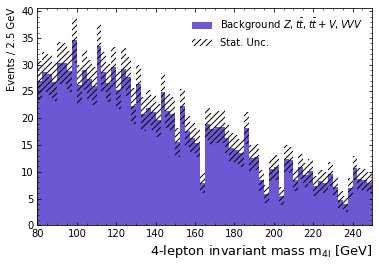

In [20]:
step_size = 2.5 * GeV

mc_x = ak.to_numpy(background_ttbar["mass"]) # define list to hold the Monte Carlo histogram entries
mc_weights = ak.to_numpy(background_ttbar["totalWeight"]) # define list to hold the Monte Carlo weights
mc_colors = samples[r'Background $Z,t\bar{t},t\bar{t}+V,VVV$']['color'] # define list to hold the colors of the Monte Carlo bars
mc_labels = r'Background $Z,t\bar{t},t\bar{t}+V,VVV$' # define list to hold the legend labels of the Monte Carlo bars

# *************
# Main plot 
# *************
main_axes = plt.gca() # get current axes

# plot the data points
# main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
#                     fmt='ko', # 'k' means black and 'o' is for circles 
#                     label='Data') 

# plot the Monte Carlo bars
mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                            weights=mc_weights, stacked=True, 
                            color=mc_colors, label=mc_labels )

mc_x_tot = mc_heights[0] # stacked background MC y-axis value

# calculate MC statistical uncertainty: sqrt(sum w^2)
mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

# plot the statistical uncertainty
main_axes.bar(bin_centres, # x
                2*mc_x_err, # heights
                alpha=0.5, # half transparency
                bottom=mc_x_tot-mc_x_err, color='none', 
                hatch="////", width=step_size, label='Stat. Unc.' )

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# add minor ticks on y-axis for main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# draw the legend
main_axes.legend( frameon=False ); # no box around the legend

## Final Analysis

Now that we understand all the steps of our analysis,
    all that's left is to import the entire ATLAS data and implement it.
The `samples` dictionary will be useful for this.

We will loop over all values in the `samples` dictionary.
Depending on whether it is a data sample or MC sample, 
    `fileString` will change,
    which opens the correct file on the open data folder.
As before, 
    the cuts, 
    mass calculations and MC weight calculations will be performed for each sample value,
    and then stored in the array.
The data will all be concatenated into `all_data` for plotting.

In [42]:
# Set luminosity to 36.6 fb-1, data size of the full release 
lumi = 36.6 

# Controls the fraction of all events analysed
fraction = 1.0 # reduce this is if you want quicker runtime (implemented in the loop over the tree)

# Define empty dictionary to hold awkward arrays
all_data = {} 

# Loop over samples
for s in samples: 

    # Print which sample is being processed
    print('Processing '+s+' samples') 

    # Define empty list to hold data
    frames = [] 

    # Loop over each file
    for val in samples[s]['list']: 
        if s == 'data': 
            prefix = "Data/" # Data prefix
        else: # MC prefix
            prefix = "MC/mc_"
        fileString = path+prefix+val+".root" # file name to open

        # start the clock
        start = time.time()
        print("\t"+val+":") 

        # Open file
        tree = uproot.open(fileString + ":analysis")
        
        sample_data = []

        # Loop over data in the tree
        for data in tree.iterate(variables + weight_variables + ["sum_of_weights", "lep_n"], 
                                 library="ak", 
                                 entry_stop=tree.num_entries*fraction):#, # process up to numevents*fraction
                                #  step_size = 10000000): 

            # Number of events in this batch
            nIn = len(data) 
            
            data = data[cut_trig(data.trigE, data.trigM)]
            data = data[cut_trig_match(data.lep_isTrigMatched)]

            # Record transverse momenta (see bonus activity for explanation)
            data['leading_lep_pt'] = data['lep_pt'][:,0]
            data['sub_leading_lep_pt'] = data['lep_pt'][:,1]
            data['third_leading_lep_pt'] = data['lep_pt'][:,2]
            data['last_lep_pt'] = data['lep_pt'][:,3]
            
            # Cuts on transverse momentum
            data = data[data['leading_lep_pt'] > 20]
            data = data[data['sub_leading_lep_pt'] > 15]
            data = data[data['third_leading_lep_pt'] > 10]
            
            data = data[ID_iso_cut(data.lep_isLooseID, 
                                   data.lep_isMediumID,  
                                   data.lep_isLooseIso, 
                                   data.lep_isLooseIso, 
                                   data.lep_type)]

            # Number Cuts
            #data = data[data['lep_n'] == 4]

            # Lepton cuts

            lep_type = data['lep_type']
            data = data[~cut_lep_type(lep_type)]
            lep_charge = data['lep_charge']
            data = data[~cut_lep_charge(lep_charge)]
            
            # Invariant Mass
            data['mass'] = calc_mass(data['lep_pt'], data['lep_eta'], data['lep_phi'], data['lep_e'])

            # Store Monte Carlo weights in the data
            if 'data' not in val: # Only calculates weights if the data is MC
                data['totalWeight'] = calc_weight(weight_variables, data)
                # data['totalWeight'] = calc_weight(data)

            # Append data to the whole sample data list
            sample_data.append(data)

            if not 'data' in val:
                nOut = sum(data['totalWeight']) # sum of weights passing cuts in this batch 
            else:
                nOut = len(data)

            elapsed = time.time() - start # time taken to process
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after

        frames.append(ak.concatenate(sample_data)) 

    all_data[s] = ak.concatenate(frames) # dictionary entry is concatenated awkward arrays

Processing data samples
	data15_periodD.exactly4lep:
		 nIn: 3424,	 nOut: 	2	 in 0.3s
	data15_periodF.exactly4lep:
		 nIn: 16234,	 nOut: 	13	 in 0.6s
	data15_periodH.exactly4lep:
		 nIn: 12152,	 nOut: 	11	 in 0.3s
	data16_periodA.exactly4lep:
		 nIn: 29275,	 nOut: 	19	 in 0.9s
	data16_periodC.exactly4lep:
		 nIn: 91124,	 nOut: 	79	 in 1.3s
	data16_periodE.exactly4lep:
		 nIn: 54896,	 nOut: 	45	 in 0.8s
	data16_periodG.exactly4lep:
		 nIn: 134798,	 nOut: 	139	 in 1.5s
	data16_periodK.exactly4lep:
		 nIn: 84130,	 nOut: 	68	 in 0.9s
	data15_periodE.exactly4lep:
		 nIn: 25092,	 nOut: 	17	 in 0.7s
	data15_periodG.exactly4lep:
		 nIn: 37101,	 nOut: 	24	 in 0.9s
	data15_periodJ.exactly4lep:
		 nIn: 67630,	 nOut: 	44	 in 1.6s
	data16_periodB.exactly4lep:
		 nIn: 72544,	 nOut: 	55	 in 0.9s
	data16_periodD.exactly4lep:
		 nIn: 174618,	 nOut: 	175	 in 2.3s
	data16_periodF.exactly4lep:
		 nIn: 118615,	 nOut: 	122	 in 1.4s
	data16_periodI.exactly4lep:
		 nIn: 205285,	 nOut: 	204	 in 2.2s
	data16_pe

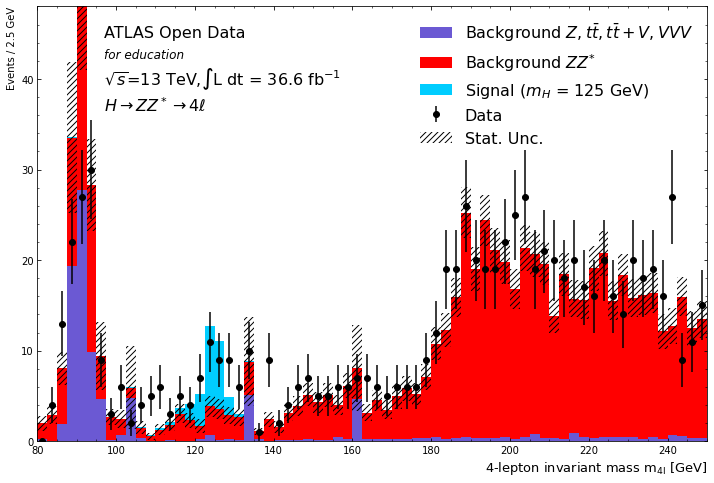

In [50]:
data_x,_ = np.histogram(ak.to_numpy(all_data['data']['mass']), 
                        bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

signal_x = ak.to_numpy(all_data[r'Signal ($m_H$ = 125 GeV)']['mass']) # histogram the signal
signal_weights = ak.to_numpy(all_data[r'Signal ($m_H$ = 125 GeV)'].totalWeight) # get the weights of the signal events
signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

mc_x = [] # define list to hold the Monte Carlo histogram entries
mc_weights = [] # define list to hold the Monte Carlo weights
mc_colors = [] # define list to hold the colors of the Monte Carlo bars
mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

for s in samples: # loop over samples
    if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
        mc_x.append( ak.to_numpy(all_data[s]['mass']) ) # append to the list of Monte Carlo histogram entries
        mc_weights.append( ak.to_numpy(all_data[s].totalWeight) ) # append to the list of Monte Carlo weights
        mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
        mc_labels.append( s ) # append to the list of Monte Carlo legend labels

# *************
# Main plot 
# *************
fig, main_axes = plt.subplots(figsize=(12, 8))

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# plot the Monte Carlo bars
mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                            weights=mc_weights, stacked=True, 
                            color=mc_colors, label=mc_labels )

mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value

# calculate MC statistical uncertainty: sqrt(sum w^2)
mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

# plot the signal bar
signal_heights = main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                weights=signal_weights, color=signal_color,
                label=r'Signal ($m_H$ = 125 GeV)')

# plot the statistical uncertainty
main_axes.bar(bin_centres, # x
                2*mc_x_err, # heights
                alpha=0.5, # half transparency
                bottom=mc_x_tot-mc_x_err, color='none', 
                hatch="////", width=step_size, label='Stat. Unc.' )

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )

# add minor ticks on y-axis for main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# Add text 'ATLAS Open Data' on plot
plt.text(0.1, # x
            0.93, # y
            'ATLAS Open Data', # text
            transform=main_axes.transAxes, # coordinate system used is that of main_axes
            fontsize=16 ) 

# Add text 'for education' on plot
plt.text(0.1, # x
            0.88, # y
            'for education', # text
            transform=main_axes.transAxes, # coordinate system used is that of main_axes
            style='italic',
            fontsize=12 ) 

# Add energy and luminosity
lumi_used = str(lumi*fraction) # luminosity to write on the plot
plt.text(0.1, # x
            0.82, # y
            '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
            transform=main_axes.transAxes,fontsize=16 ) # coordinate system used is that of main_axes

# Add a label for the analysis carried out
plt.text(0.1, # x
            0.76, # y
            r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
            transform=main_axes.transAxes,fontsize=16 ) # coordinate system used is that of main_axes

# draw the legend
main_axes.legend( frameon=False, fontsize=16 ) # no box around the legend

### Signal Significance

We can do some analysis to study how significant the signal is compared to the background. 
One method is to check a quantity known as the signal significance $S$,
    which is defined by 
$$ S = \frac{N_\text{sig}}{\sqrt{N_\text{bg}}}  $$
where $ N_\text{sig} $ and $N_\text{bg}$ are the number of signal and background points respectively.
A larger $S$ represents a better signal-to-background ratio,
    and a more significant signal peak.
To calculate $N_\text{sig}$, 
    we can look at the plot and sum over the number of events of our Monte-Carlo signal.
The signal range roughly corresponds to the bins from $115 \,\text{GeV}$ to $130 \, \text{GeV}$.
$N_\text{bg}$ then corresponds to the number of background events in those same bins.

In [45]:
# Signal stacked height
signal_tot = signal_heights[0] + mc_x_tot

# Peak of signal
print(signal_tot[18])

# Neighbouring bins
print(signal_tot[17:20])

# Signal and background events
N_sig = signal_tot[17:20].sum()
N_bg = mc_x_tot[17:20].sum()

# Signal significance calculation
signal_significance = N_sig/np.sqrt(N_bg + 0.3 * N_bg**2) # EXPLAIN THE 0.3
print(f"\nResults:\n{N_sig = }\n{N_bg = }\n{signal_significance = }\n")

11.094884981667025
[12.69896722 11.09488498  4.93528783]

Results:
N_sig = np.float64(28.729140024845144)
N_bg = np.float64(10.300928352079978)
signal_significance = np.float64(4.425965281174207)



# Testing with old code

In [24]:
def calc_weight(events):
    return (
        (lumi*1000*events.corrected_xsec
        * events.mcWeight
        * events.ScaleFactor_PILEUP
        * events.ScaleFactor_ELE
        * abs(events.ScaleFactor_MUON))/(events.sum_of_weights)
        #* events.scaleFactor_LepTRIGGER
    )

In [25]:
def calc_weight(weight_variables, events):
    total_weight = lumi * 1000 / events["sum_of_weights"]
    for variable in weight_variables:
        total_weight = total_weight * abs(events[variable])
    return total_weight

# Verify that we get the same answer
print(calc_weight(weight_variables, event))

0.6042907351111703


In [26]:
def calc_mass(lep_pt, lep_eta, lep_phi, lep_e):
    # construct awkward 4-vector array
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "e": lep_e})
    # calculate invariant mass of first 4 leptons
    # [:, i] selects the i-th lepton in each event
    # .M calculates the invariant mass
    return (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M

In [27]:
# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    return lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2] + lep_charge[:, 3] != 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2] + lep_type[:, 3]
    return (sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52)

In [28]:
def get_data_from_files():

    data = {} # define empty dictionary to hold awkward arrays
    for s in samples: # loop over samples
        #print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            prefix = ""
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"
            fileString = path+prefix+val+".root" # file name to open
            if not "https" in fileString and not os.path.isfile(fileString):
                print("WARNING \t File %s does not exists. Skipping"%fileString)
                continue
            #print(fileString,val)
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append array returned from read_file to list of awkward arrays
        data[s] = ak.concatenate(frames) # dictionary entry is concatenated awkward arrays
    
    return data # return dictionary of awkward arrays

In [29]:
import time
fraction=0.25

def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = [] # define empty list to hold all data for this sample
    
    # open the tree called mini using a context manager (will automatically close files/resources)
    with uproot.open(path + ":analysis") as tree:
        numevents = tree.num_entries # number of events
        #if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
        for data in tree.iterate(['lep_n','lep_pt','lep_eta','lep_phi','lep_z0','lep_d0',
                                  'lep_e','lep_charge','lep_type', 'lep_isTightID','lep_topoetcone20',
                                  'lep_ptvarcone30','lep_isLooseID','lep_isMediumID',
                                  # add more variables here if you make cuts on them 
                                  'mcWeight','ScaleFactor_PILEUP',
                                  'ScaleFactor_ELE','ScaleFactor_MUON',
                                  'sum_of_weights','corrected_xsec','xsec','num_events',
                                 'trigE','trigM'],
                                  #'ScaleFactor_LepTRIGGER'], # variables to calculate Monte Carlo weight
                                 library="ak", # choose output type as awkward array
                                 entry_stop=numevents*fraction): # process up to numevents*fraction

            nIn = len(data) # number of events in this batch
            
            data = data[data['lep_n'] == 4]
            
            # Produce flat variables for each lepton so that we can easilly cut on the later
            # ... or convert to hdf5 files
            for i in range(0,4):
                data[f'lep_pt{i+1}'] = data['lep_pt'][:,i]
                data[f'lep_tightID{i+1}'] = data['lep_isTightID'][:,i]
                data[f'lep_looseID{i+1}'] = data['lep_isLooseID'][:,i]
                data[f'lep_mediumID{i+1}'] = data['lep_isMediumID'][:,i]
                data[f'lep_topoetcone20{i+1}'] = data['lep_topoetcone20'][:,i]/data['lep_pt'][:,i]
                data[f'lep_ptvarcone30{i+1}'] = data['lep_ptvarcone30'][:,i]/data['lep_pt'][:,i]
                data[f'lep_type{i+1}'] = data['lep_type'][:,i]
                data[f'lep_z0sintheta{i+1}'] = data['lep_z0'][:,i]*np.sin(2*np.arctan(np.exp(-1.0*data["lep_eta"][:,i])))
                data[f'lep_d0{i+1}'] = data['lep_d0'][:,i]
        
            data = data[data['trigE'] | data['trigM']]
            
            # Isolation as explained in Section 4 (Event selection) in paper
            data = data[((data['lep_type1'] == 13) & (data['lep_topoetcone201']<0.3)) | \
                        ((data['lep_type1'] == 11) & (data['lep_topoetcone201']<0.2))]
            data = data[((data['lep_type2'] == 13) & (data['lep_topoetcone202']<0.3)) | \
                        ((data['lep_type2'] == 11) & (data['lep_topoetcone202']<0.2))]
            data = data[((data['lep_type3'] == 13) & (data['lep_topoetcone203']<0.3)) | \
                        ((data['lep_type3'] == 11) & (data['lep_topoetcone203']<0.2))]
            data = data[((data['lep_type4'] == 13) & (data['lep_topoetcone204']<0.3)) | \
                        ((data['lep_type4'] == 11) & (data['lep_topoetcone204']<0.2))]
            
            data = data[data['lep_ptvarcone301']<0.15]
            data = data[data['lep_ptvarcone302']<0.15]
            data = data[data['lep_ptvarcone303']<0.15]
            data = data[data['lep_ptvarcone304']<0.15]
            
            # Lepton identification as explained in Section 4 (Event selection) in paper
            data = data[((data['lep_type1'] == 13) ) | \
                        ((data['lep_type1'] == 11) & (abs(data['lep_looseID1'])==1))]
            data = data[((data['lep_type2'] == 13) ) | \
                        ((data['lep_type2'] == 11) & (abs(data['lep_looseID2'])==1))]
            data = data[((data['lep_type3'] == 13) ) | \
                        ((data['lep_type3'] == 11) & (abs(data['lep_looseID3'])==1))]
            data = data[((data['lep_type4'] == 13) ) | \
                        ((data['lep_type4'] == 11) & (abs(data['lep_looseID4'])==1))]
            
            # Cuts on transverse momentum
            data = data[data['lep_pt1'] > 20]
            data = data[data['lep_pt2'] > 15]
            data = data[data['lep_pt3'] > 10]
            
            if 'data' not in sample: # only do this for Monte Carlo simulation files
                data['totalWeight'] = calc_weight(weight_variables, data)
                # data['totalWeight'] = calc_weight(data)
                
            # cut on lepton charge using the function cut_lep_charge defined above
            data = data[~cut_lep_charge(data.lep_charge)]

            # cut on lepton type using the function cut_lep_type defined above
            data = data[~cut_lep_type(data.lep_type)]

            # calculation of 4-lepton invariant mass using the function calc_mllll defined above
            data['mass'] = calc_mass(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_e)
            
            # multiple array columns can be printed at any stage like this
            #print(data[['lep_pt','lep_eta']])
            
            if not 'data' in sample:
                nOut = sum(data['totalWeight']) # sum of weights passing cuts in this batch 
            else:
                nOut = len(data)
            data_all.append(data) # append array from this batch
            elapsed = time.time() - start # time taken to process
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return ak.concatenate(data_all) # return array containing events passing all cuts

In [30]:
import time
fraction=0.25

def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = [] # define empty list to hold all data for this sample
    
    # open the tree called analysis using a context manager (will automatically close files/resources)
    with uproot.open(path + ":analysis") as tree:
        numevents = tree.num_entries # number of events
        #if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
        for data in tree.iterate(variables + weight_variables + ['sum_of_weights'],
                                  #'ScaleFactor_LepTRIGGER'], # variables to calculate Monte Carlo weight
                                 library="ak", # choose output type as awkward array
                                 entry_stop=numevents*fraction): # process up to numevents*fraction

            nIn = len(data) # number of events in this batch
            
            if 'data' not in sample: # only do this for Monte Carlo simulation files
                data['totalWeight'] = calc_weight(weight_variables, data)
                # data['totalWeight'] = calc_weight(data)
                
            # cut on lepton charge using the function cut_lep_charge defined above
            data = data[~cut_lep_charge(data.lep_charge)]

            # cut on lepton type using the function cut_lep_type defined above
            data = data[~cut_lep_type(data.lep_type)]

            # calculation of 4-lepton invariant mass using the function calc_mllll defined above
            data['mass'] = calc_mass(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_e)
            
            if not 'data' in sample:
                nOut = sum(data['totalWeight']) # sum of weights passing cuts in this batch 
            else:
                nOut = len(data)
            data_all.append(data) # append array from this batch
            elapsed = time.time() - start # time taken to process
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return ak.concatenate(data_all) # return array containing events passing all cuts

In [31]:
start = time.time() # time at start of whole processing
all_data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

	Processing: data15_periodD.exactly4lep
		 nIn: 856,	 nOut: 	226	 in 0.1s
	Processing: data15_periodF.exactly4lep
		 nIn: 4058,	 nOut: 	1112	 in 0.2s
	Processing: data15_periodH.exactly4lep
		 nIn: 3038,	 nOut: 	873	 in 0.2s
	Processing: data16_periodA.exactly4lep
		 nIn: 7318,	 nOut: 	2132	 in 0.3s
	Processing: data16_periodC.exactly4lep
		 nIn: 22781,	 nOut: 	7152	 in 0.4s
	Processing: data16_periodE.exactly4lep
		 nIn: 13724,	 nOut: 	4450	 in 0.3s
	Processing: data16_periodG.exactly4lep
		 nIn: 33699,	 nOut: 	10498	 in 0.4s
	Processing: data16_periodK.exactly4lep
		 nIn: 21032,	 nOut: 	6586	 in 0.4s
	Processing: data15_periodE.exactly4lep
		 nIn: 6273,	 nOut: 	1720	 in 0.3s
	Processing: data15_periodG.exactly4lep
		 nIn: 9275,	 nOut: 	2574	 in 0.4s
	Processing: data15_periodJ.exactly4lep
		 nIn: 16907,	 nOut: 	4936	 in 0.4s
	Processing: data16_periodB.exactly4lep
		 nIn: 18136,	 nOut: 	5696	 in 0.4s
	Processing: data16_periodD.exactly4lep
		 nIn: 43654,	 nOut: 	13809	 in 0.6s
	Proce

In [32]:
def plot_data(data):
    
    var = 'mass'

    xmin = 80 * GeV
    xmax = 170 * GeV
    step_size = 2.5 * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(ak.to_numpy(data['data'][var]), 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)'][var]) # histogram the signal
    signal_weights = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)'].totalWeight) # get the weights of the signal events
    signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples.keys(): # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append( ak.to_numpy(data[s][var]) ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( ak.to_numpy(data[s].totalWeight) ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    

    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, 
                                stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    # main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.2, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=16 ) 
    
    # Add text 'for education' on plot
    plt.text(0.2, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=10 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.2, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.2, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False, bbox_to_anchor=(0.5, 1.0) ) # no box around the legend
    
    # plt.ylim(0, 40)
    
    return mc_weights

[array([4.94311701e-01, 5.37356828e-01, 5.06070896e-01, ...,
        2.13696166e-04, 2.32017789e-04, 5.39415304e-03]),
 array([0.33354879, 0.03545502, 0.04399362, ..., 0.08127777, 0.09668575,
        0.07537842])]

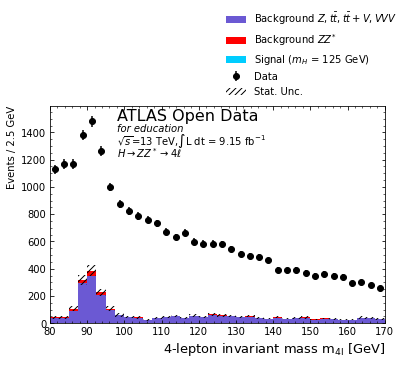

In [33]:
plot_data(all_data)